In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import scipy
from math import ceil
import re

## Load & Clean Data

In [2]:
data = pd.read_csv('/Users/katepoole/Documents/KINGS/~Dissertation/~Data/LLM-perf A100 Load 2024_0620.csv')

In [4]:
data.tail()

,Model,Experiment,Prefill (s),Decode (tokens/s),Memory (MB),Energy (tokens/kWh),Open LLM Score (%),Backend,Precision,Quantization,Attention,Kernel,End-to-End (s),Architecture,Params (B)
457,EleutherAI/pythia-70m,4bit-gptq-exllama-v1-eager,0.010,104.628,193.845,876577.936,28.93*,pytorch,float16,GPTQ.4bit,Eager,GPTQ.ExllamaV1,0.609,Unknown,0
458,EleutherAI/pythia-70m,4bit-gptq-exllama-v2-eager,0.010,107.004,193.845,914642.949,28.93*,pytorch,float16,GPTQ.4bit,Eager,GPTQ.ExllamaV2,0.595,Unknown,0
459,EleutherAI/pythia-70m,4bit-gptq-exllama-v2-fa2,0.009,115.952,193.844,991460.772,28.93*,pytorch,float16,GPTQ.4bit,FAv2,GPTQ.ExllamaV2,0.551,Unknown,0
460,EleutherAI/pythia-70m,4bit-gptq-exllama-v1-fa2,0.009,116.298,193.844,998412.513,28.93*,pytorch,float16,GPTQ.4bit,FAv2,GPTQ.ExllamaV1,0.549,Unknown,0
461,openai-community/gpt2,float16-fa2,0.007,147.371,328.799,1212590.352,28.53,pytorch,float16,Unquantized,FAv2,No Kernel,0.432,GPT2LMHeadModel,0


In [8]:
data[data.isna().any(axis=1)]
# no NAs, good

,Model,Experiment,Prefill (s),Decode (tokens/s),Memory (MB),Energy (tokens/kWh),Open LLM Score (%),Backend,Precision,Quantization,Attention,Kernel,End-to-End (s),Architecture,Params (B)


## Exploratory Data Analysis

In [10]:
data['Energy (tokens/kWh)'].max()

1492424.358

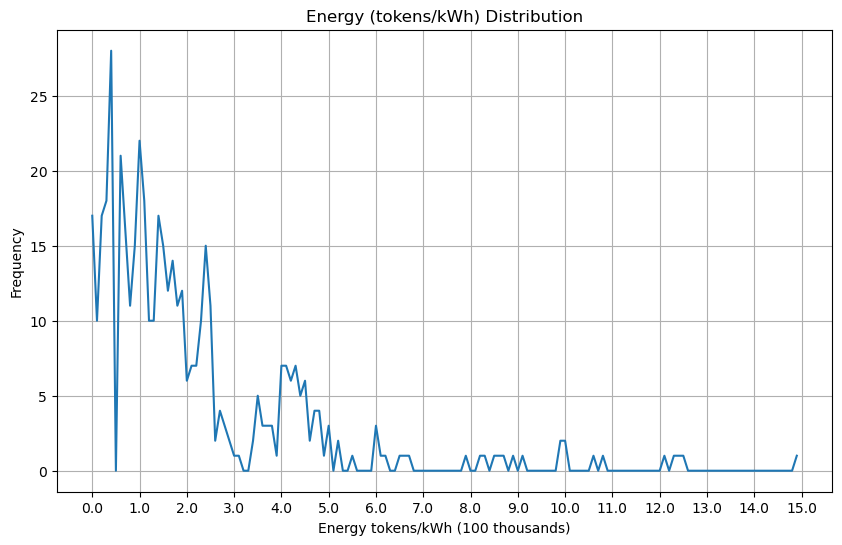

In [16]:
# Bin the data for line chart increments
bins = np.arange(0, data['Energy (tokens/kWh)'].max() + 10000, 10000)
data['Energy_bins'] = pd.cut(data['Energy (tokens/kWh)'], bins=bins, labels=bins[:-1])

# Calculate the frequency of each bin
energy_distribution = data['Energy_bins'].value_counts().sort_index()

# Convert the index to numeric type for plotting
energy_distribution.index = energy_distribution.index.astype(float)

# Plot the distribution as a line chart using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(energy_distribution.index, energy_distribution.values, linestyle='-')
plt.title('Energy (tokens/kWh) Distribution')
plt.xlabel('Energy tokens/kWh (100 thousands)')
plt.ylabel('Frequency')

# Set x-ticks increment to 500,000 and add 'M' to denote millions
xticks = np.arange(0, data['Energy (tokens/kWh)'].max() + 100000, 100000)
xtick_labels = [f'{x/1e5:.1f}' for x in xticks]
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.grid(True)
plt.show()

#### Drill down within up to 1M tokens chunk

In [17]:
# Split first bin 0 - 500k for greater granularity 
data_to_500k = data[data['Energy (tokens/kWh)'] <= 500000]

/var/folders/m6/t786km0s2gj___42n4vm3gnr0000gn/T/ipykernel_47011/1525694969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_500k['Energy_bins'] = pd.cut(data_to_500k['Energy (tokens/kWh)'], bins=bins, labels=bins[:-1])


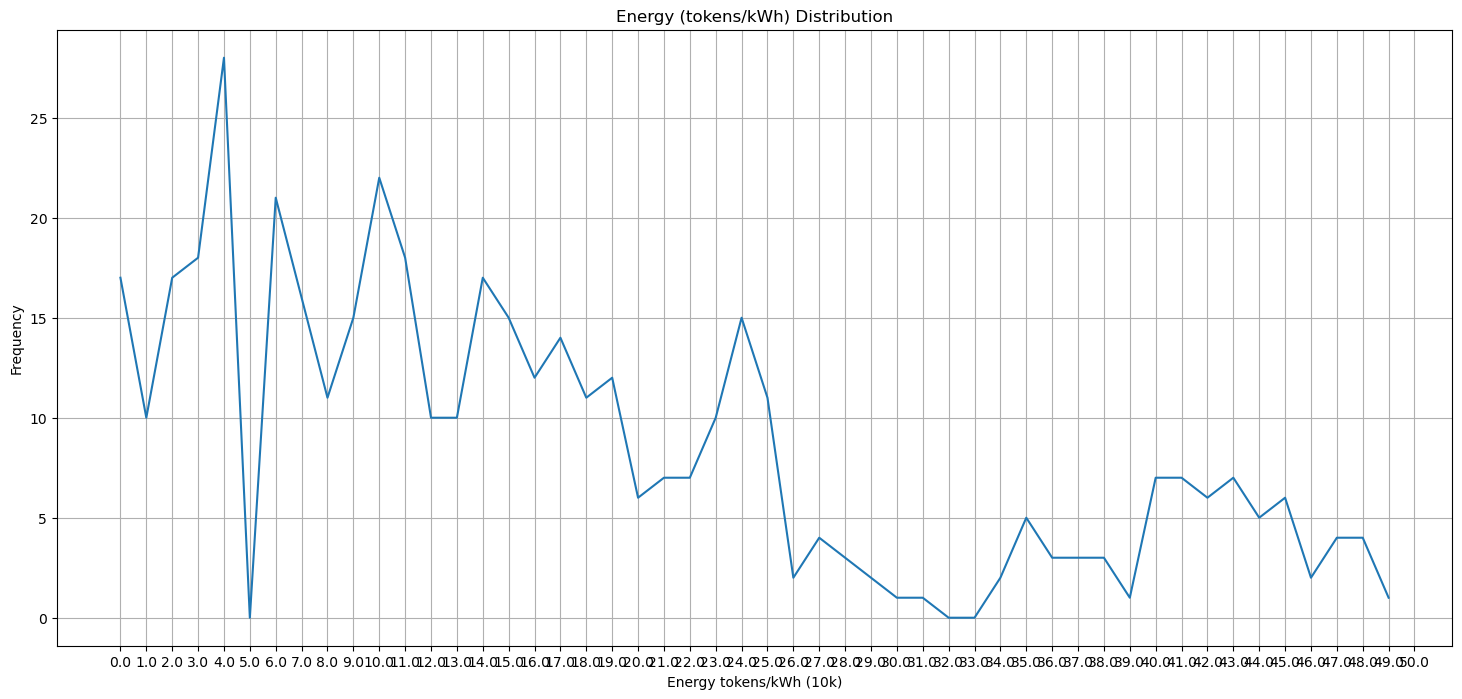

In [19]:
# plot up to 1M data
# Bin the data for the histogram
bins = np.arange(0, data_to_500k['Energy (tokens/kWh)'].max() + 10000, 10000)
data_to_500k['Energy_bins'] = pd.cut(data_to_500k['Energy (tokens/kWh)'], bins=bins, labels=bins[:-1])

# Calculate the frequency of each bin
energy_distribution = data_to_500k['Energy_bins'].value_counts().sort_index()

# Convert the index to numeric type for plotting
energy_distribution.index = energy_distribution.index.astype(float)

# Plot the distribution as a line chart using matplotlib
plt.figure(figsize=(18, 8))
plt.plot(energy_distribution.index, energy_distribution.values, linestyle='-')
plt.title('Energy (tokens/kWh) Distribution')
plt.xlabel('Energy tokens/kWh (10k)')
plt.ylabel('Frequency')

# Set x-ticks increment to 500,000 and add 'M' to denote millions
xticks = np.arange(0, data_to_500k['Energy (tokens/kWh)'].max() + 10000, 10000)
xtick_labels = [f'{x/10000}' for x in xticks]
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.grid(True)
plt.show()

In [21]:
data_to_500k[data_to_500k['Energy (tokens/kWh)'] < 10000]

,Model,Experiment,Prefill (s),Decode (tokens/s),Memory (MB),Energy (tokens/kWh),Open LLM Score (%),Backend,Precision,Quantization,Attention,Kernel,End-to-End (s),Architecture,Params (B),Energy_bins
0,Qwen/Qwen1.5-110B,4bit-gptq-exllama-v2-eager,2.486,0.398,65311.037,2661.495,75.42*,pytorch,float16,GPTQ.4bit,Eager,GPTQ.ExllamaV2,149.921,Qwen2ForCausalLM,110,0.0
1,Qwen/Qwen1.5-110B,4bit-gptq-exllama-v1-fa2,2.513,0.421,65311.036,2633.025,75.42*,pytorch,float16,GPTQ.4bit,FAv2,GPTQ.ExllamaV1,151.799,Qwen2ForCausalLM,110,0.0
2,Qwen/Qwen1.5-110B,4bit-gptq-exllama-v1-eager,2.515,0.424,65311.037,2662.679,75.42*,pytorch,float16,GPTQ.4bit,Eager,GPTQ.ExllamaV1,151.175,Qwen2ForCausalLM,110,0.0
3,Qwen/Qwen1.5-110B,4bit-gptq-exllama-v2-sdpa,2.499,0.425,65311.036,2666.191,75.42*,pytorch,float16,GPTQ.4bit,SDPA,GPTQ.ExllamaV2,150.500,Qwen2ForCausalLM,110,0.0
4,Qwen/Qwen1.5-110B,4bit-gptq-exllama-v1-sdpa,2.480,0.428,65311.036,2664.976,75.42*,pytorch,float16,GPTQ.4bit,SDPA,GPTQ.ExllamaV1,149.561,Qwen2ForCausalLM,110,0.0
8,Qwen/Qwen1.5-72B,4bit-gptq-exllama-v1-fa2,1.659,0.640,45374.151,3969.019,72.91*,pytorch,float16,GPTQ.4bit,FAv2,GPTQ.ExllamaV1,100.136,Qwen2ForCausalLM,72,0.0
9,Qwen/Qwen1.5-72B,4bit-gptq-exllama-v2-fa2,1.640,0.647,45374.151,4022.375,72.91*,pytorch,float16,GPTQ.4bit,FAv2,GPTQ.ExllamaV2,98.929,Qwen2ForCausalLM,72,0.0
10,Qwen/Qwen1.5-72B,4bit-gptq-exllama-v2-sdpa,1.645,0.650,45374.151,4074.884,72.91*,pytorch,float16,GPTQ.4bit,SDPA,GPTQ.ExllamaV2,98.609,Qwen2ForCausalLM,72,0.0
11,Qwen/Qwen1.5-72B,4bit-gptq-exllama-v1-sdpa,1.640,0.651,45374.151,4083.113,72.91*,pytorch,float16,GPTQ.4bit,SDPA,GPTQ.ExllamaV1,98.385,Qwen2ForCausalLM,72,0.0
12,Qwen/Qwen1.5-72B,4bit-gptq-exllama-v1-eager,1.641,0.652,45374.152,4086.555,72.91*,pytorch,float16,GPTQ.4bit,Eager,GPTQ.ExllamaV1,98.294,Qwen2ForCausalLM,72,0.0


Qwen & 01-ai models are least efficient -- let's see if these are the same as the ones in the A10 table

In [23]:
# look at the highest energy scores
data[data['Energy (tokens/kWh)'] > 1000000]

,Model,Experiment,Prefill (s),Decode (tokens/s),Memory (MB),Energy (tokens/kWh),Open LLM Score (%),Backend,Precision,Quantization,Attention,Kernel,End-to-End (s),Architecture,Params (B),Energy_bins
431,EleutherAI/gpt-neo-125m,float16-eager,0.009,119.461,363.873,1006877.327,29.47,pytorch,float16,Unquantized,Eager,No Kernel,0.533,GPTNeoForCausalLM,0,1000000.0
432,EleutherAI/gpt-neo-125m,bfloat16-eager,0.009,121.822,363.873,1003006.109,29.47,pytorch,bfloat16,Unquantized,Eager,No Kernel,0.526,GPTNeoForCausalLM,0,1000000.0
433,EleutherAI/gpt-neo-125m,float32-eager,0.010,124.599,657.858,1064993.470,29.47,pytorch,float32,Unquantized,Eager,No Kernel,0.514,GPTNeoForCausalLM,0,1060000.0
434,EleutherAI/gpt-neo-125m,float16-fa2,0.007,145.789,363.871,1233644.886,29.47,pytorch,float16,Unquantized,FAv2,No Kernel,0.436,GPTNeoForCausalLM,0,1230000.0
435,EleutherAI/gpt-neo-125m,bfloat16-fa2,0.007,149.464,363.871,1249611.184,29.47,pytorch,bfloat16,Unquantized,FAv2,No Kernel,0.427,GPTNeoForCausalLM,0,1240000.0
440,facebook/opt-125m,bfloat16-fa2,0.012,87.225,312.411,1088969.190,29.15,pytorch,bfloat16,Unquantized,FAv2,No Kernel,0.740,OPTForCausalLM,0,1080000.0
443,facebook/opt-125m,bfloat16-eager,0.007,153.138,312.416,1254978.241,29.15,pytorch,bfloat16,Unquantized,Eager,No Kernel,0.418,OPTForCausalLM,0,1250000.0
444,facebook/opt-125m,float16-fa2,0.006,169.275,312.411,1492424.358,29.15,pytorch,float16,Unquantized,FAv2,No Kernel,0.372,OPTForCausalLM,0,1490000.0
461,openai-community/gpt2,float16-fa2,0.007,147.371,328.799,1212590.352,28.53,pytorch,float16,Unquantized,FAv2,No Kernel,0.432,GPT2LMHeadModel,0,1210000.0


low open-LLM scores, makes sense

In [24]:
# Remove * from Open LLM score variable
data['Open LLM Score (stripped)'] = data['Open LLM Score (%)'].str.replace('*','').astype(float)

/var/folders/m6/t786km0s2gj___42n4vm3gnr0000gn/T/ipykernel_47011/3419938314.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Open LLM Score (stripped)'] = data['Open LLM Score (%)'].str.replace('*','').astype(float)


In [25]:
data.head()
# looks good 

,Model,Experiment,Prefill (s),Decode (tokens/s),Memory (MB),Energy (tokens/kWh),Open LLM Score (%),Backend,Precision,Quantization,Attention,Kernel,End-to-End (s),Architecture,Params (B),Energy_bins,Open LLM Score (stripped)
0,Qwen/Qwen1.5-110B,4bit-gptq-exllama-v2-eager,2.486,0.398,65311.037,2661.495,75.42*,pytorch,float16,GPTQ.4bit,Eager,GPTQ.ExllamaV2,149.921,Qwen2ForCausalLM,110,0.0,75.42
1,Qwen/Qwen1.5-110B,4bit-gptq-exllama-v1-fa2,2.513,0.421,65311.036,2633.025,75.42*,pytorch,float16,GPTQ.4bit,FAv2,GPTQ.ExllamaV1,151.799,Qwen2ForCausalLM,110,0.0,75.42
2,Qwen/Qwen1.5-110B,4bit-gptq-exllama-v1-eager,2.515,0.424,65311.037,2662.679,75.42*,pytorch,float16,GPTQ.4bit,Eager,GPTQ.ExllamaV1,151.175,Qwen2ForCausalLM,110,0.0,75.42
3,Qwen/Qwen1.5-110B,4bit-gptq-exllama-v2-sdpa,2.499,0.425,65311.036,2666.191,75.42*,pytorch,float16,GPTQ.4bit,SDPA,GPTQ.ExllamaV2,150.500,Qwen2ForCausalLM,110,0.0,75.42
4,Qwen/Qwen1.5-110B,4bit-gptq-exllama-v1-sdpa,2.480,0.428,65311.036,2664.976,75.42*,pytorch,float16,GPTQ.4bit,SDPA,GPTQ.ExllamaV1,149.561,Qwen2ForCausalLM,110,0.0,75.42


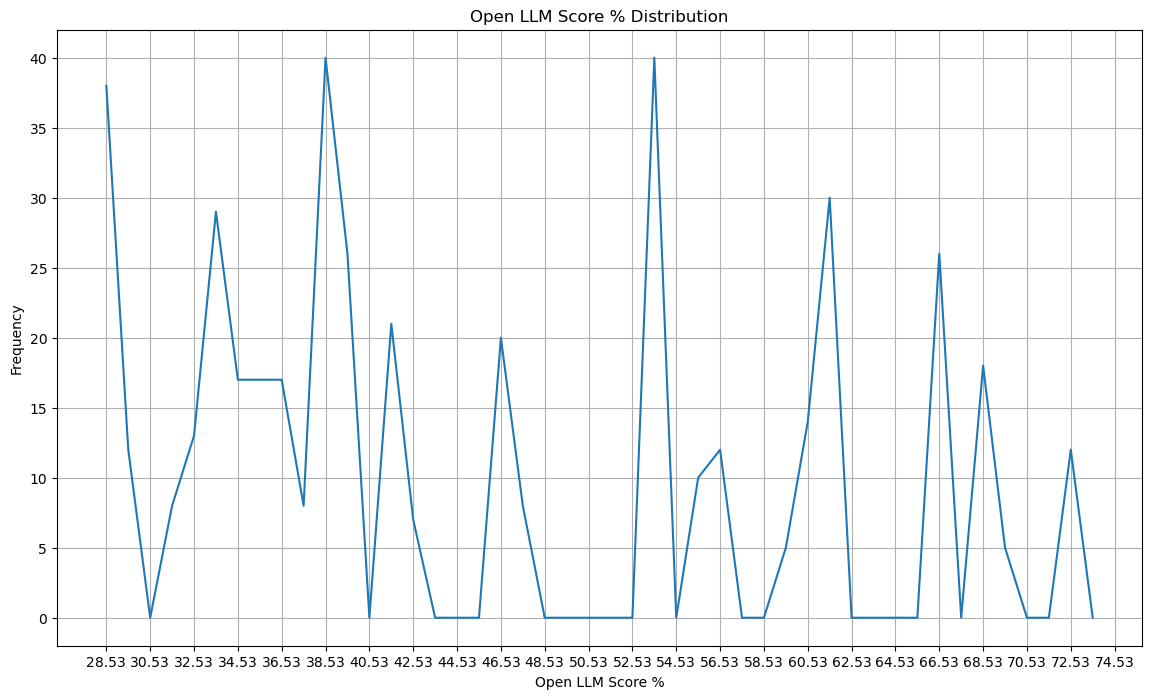

In [29]:
# Bin the data for line chart increments - Open LLM Score
bins = np.arange(data['Open LLM Score (stripped)'].min(), data['Open LLM Score (stripped)'].max(), 1)
data['llm_score_bins'] = pd.cut(data['Open LLM Score (stripped)'], bins=bins, labels=bins[:-1])

# Calculate the frequency of each bin
llm_score_distribution = data['llm_score_bins'].value_counts().sort_index()

# Convert the index to numeric type for plotting
llm_score_distribution.index = llm_score_distribution.index.astype(float)

# Plot the distribution as a line chart using matplotlib
plt.figure(figsize=(14, 8))
plt.plot(llm_score_distribution.index, llm_score_distribution.values, linestyle='-')
plt.title('Open LLM Score % Distribution')
plt.xlabel('Open LLM Score %')
plt.ylabel('Frequency')

# Set x-ticks increment to 500,000 and add 'M' to denote millions
xticks = np.arange(data['Open LLM Score (stripped)'].min(), data['Open LLM Score (stripped)'].max(), 2)
plt.xticks(ticks=xticks)

plt.grid(True)
plt.show()

Scores are all over the place, vary from 29% to ~69%

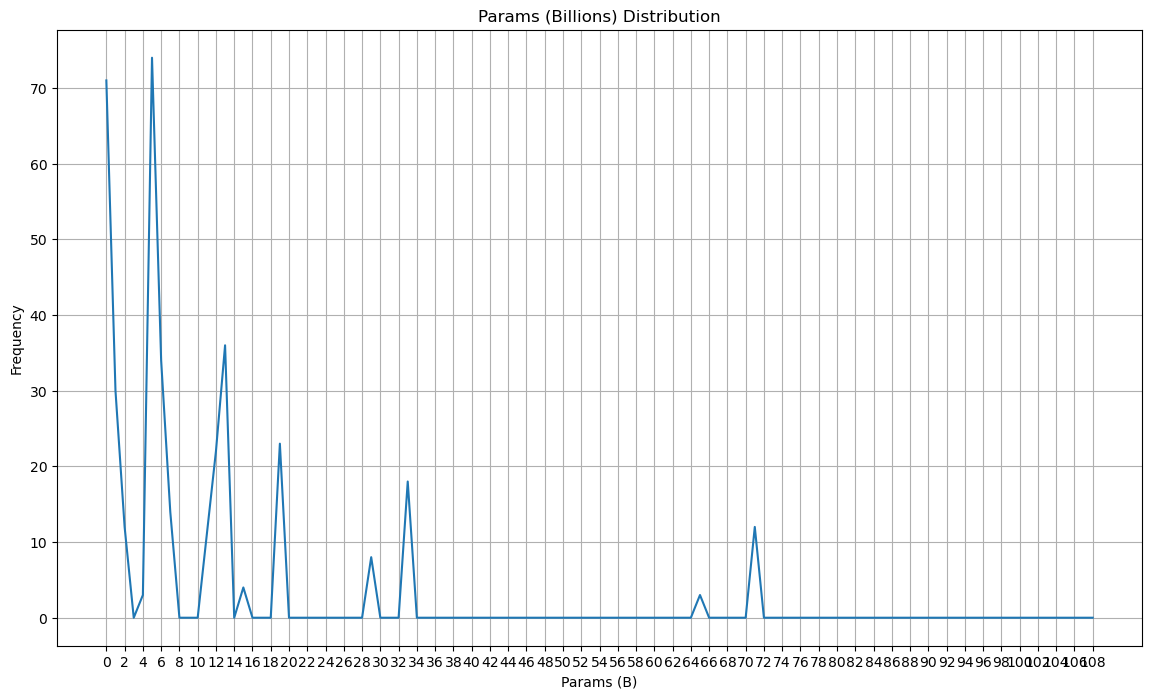

In [30]:
# Bin the data for line chart increments - Params(B)
bins = np.arange(data['Params (B)'].min(), data['Params (B)'].max(), 1)
data['params_bins'] = pd.cut(data['Params (B)'], bins=bins, labels=bins[:-1])

# Calculate the frequency of each bin
params_distribution = data['params_bins'].value_counts().sort_index()

# Convert the index to numeric type for plotting
params_distribution.index = params_distribution.index.astype(float)

# Plot the distribution as a line chart using matplotlib
plt.figure(figsize=(14, 8))
plt.plot(params_distribution.index, params_distribution.values, linestyle='-')
plt.title('Params (Billions) Distribution')
plt.xlabel('Params (B)')
plt.ylabel('Frequency')

# Set x-ticks increment to 500,000 and add 'M' to denote millions
xticks = np.arange(data['Params (B)'].min(), data['Params (B)'].max(), 2)
plt.xticks(ticks=xticks)

plt.grid(True)
plt.show()

Mostly <34b parameters, some at the high end (>100b)

In [31]:
data['Params (B)'].max()

110

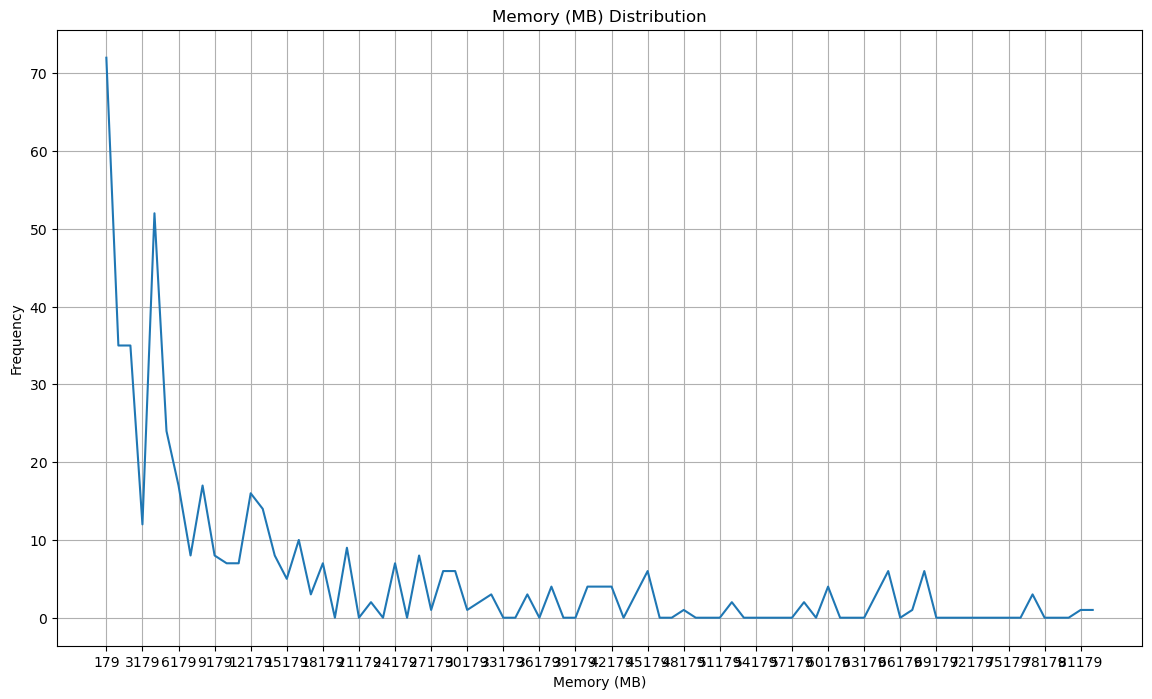

In [35]:
# Bin the data for line chart increments - Memory (MB)
bins = np.arange(data['Memory (MB)'].min(), data['Memory (MB)'].max(), 1000)
data['memory_bins'] = pd.cut(data['Memory (MB)'], bins=bins, labels=bins[:-1])

# Calculate the frequency of each bin
memory_distribution = data['memory_bins'].value_counts().sort_index()

# Convert the index to numeric type for plotting
memory_distribution.index = memory_distribution.index.astype(float)

# Plot the distribution as a line chart using matplotlib
plt.figure(figsize=(14, 8))
plt.plot(memory_distribution.index, memory_distribution.values, linestyle='-')
plt.title('Memory (MB) Distribution')
plt.xlabel('Memory (MB)')
plt.ylabel('Frequency')

# Set x-ticks increment to 500,000 and add 'M' to denote millions
xticks = np.arange(data['Memory (MB)'].min(), data['Memory (MB)'].max(), 3000)
plt.xticks(ticks=xticks)

plt.grid(True)
plt.show()

Consistent downwards trend in used Memory

### Skewness scores
Some of the variable distributions appear slightly skewed, let's look at their skewness scores

In [36]:
results=[] 

for col in data.select_dtypes(include=['number']):
    score = scipy.stats.skew(data[col], axis=0, bias=True)
    results.append((col, score))

In [37]:
print('Skewness scores:')

for col, score in results:
    print(f"Column: {col}, Skewness: {score}")

Skewness scores:
Column: Prefill (s), Skewness: 4.674319822467255
Column: Decode (tokens/s), Skewness: 2.1104549041774434
Column: Memory (MB), Skewness: 1.9099483299133273
Column: Energy (tokens/kWh), Skewness: 2.338871177671261
Column: End-to-End (s), Skewness: 5.340859837759363
Column: Params (B), Skewness: 3.3651646406482283
Column: Open LLM Score (stripped), Skewness: 0.47902976978201306


Some right sided skewness, keep in mind for analysis. High with 'Params', 'End-to-end', and 'Prefill' variables. Apply normalization to mitigate if needed.

# Scatterplots for variable against variable to discern relationships

In [50]:
def gg_scatterplots(data, y_variable="Energy (tokens/kWh)"):
    # Get all variable names except the y_variable
    #x_variables = [col for col in data.columns if col != y_variable]
    x_variables = [col for col in data.columns if col not in (y_variable, 'Open LLM Score (%)', 'Energy_bins', 'params_bins', 'memory_bins', 'Backend', 'llm_score_bins')]

    # Determine the number of rows and columns for the subplots
    n_cols = 3
    n_rows = ceil(len(x_variables) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, variable in enumerate(x_variables):
        # Create readable labels
        x_label = re.sub(r"[._]", " ", variable).title()
        plot_title = f"{x_label} vs {y_variable}"

        # Create scatter plot 
        sns.scatterplot(x=variable, y=y_variable, data=data, ax=axes[idx], color="royalblue", marker='o')
        # Add tight regression line 
        #sns.lineplot(x=variable, y=y_variable, data=data, ax=axes[idx], color="black", linestyle='dashed')  
        ## remove comment ^ to add regression line

        # Set titles and labels
        axes[idx].set_title(plot_title, fontsize=10)
        axes[idx].set_xlabel(x_label)
        axes[idx].set_ylabel(y_variable)

        # Adjust x-axis ticks for readability
        axes[idx].xaxis.set_major_locator(MaxNLocator(nbins=10))

    # Remove any unused subplots
    for idx in range(len(x_variables), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

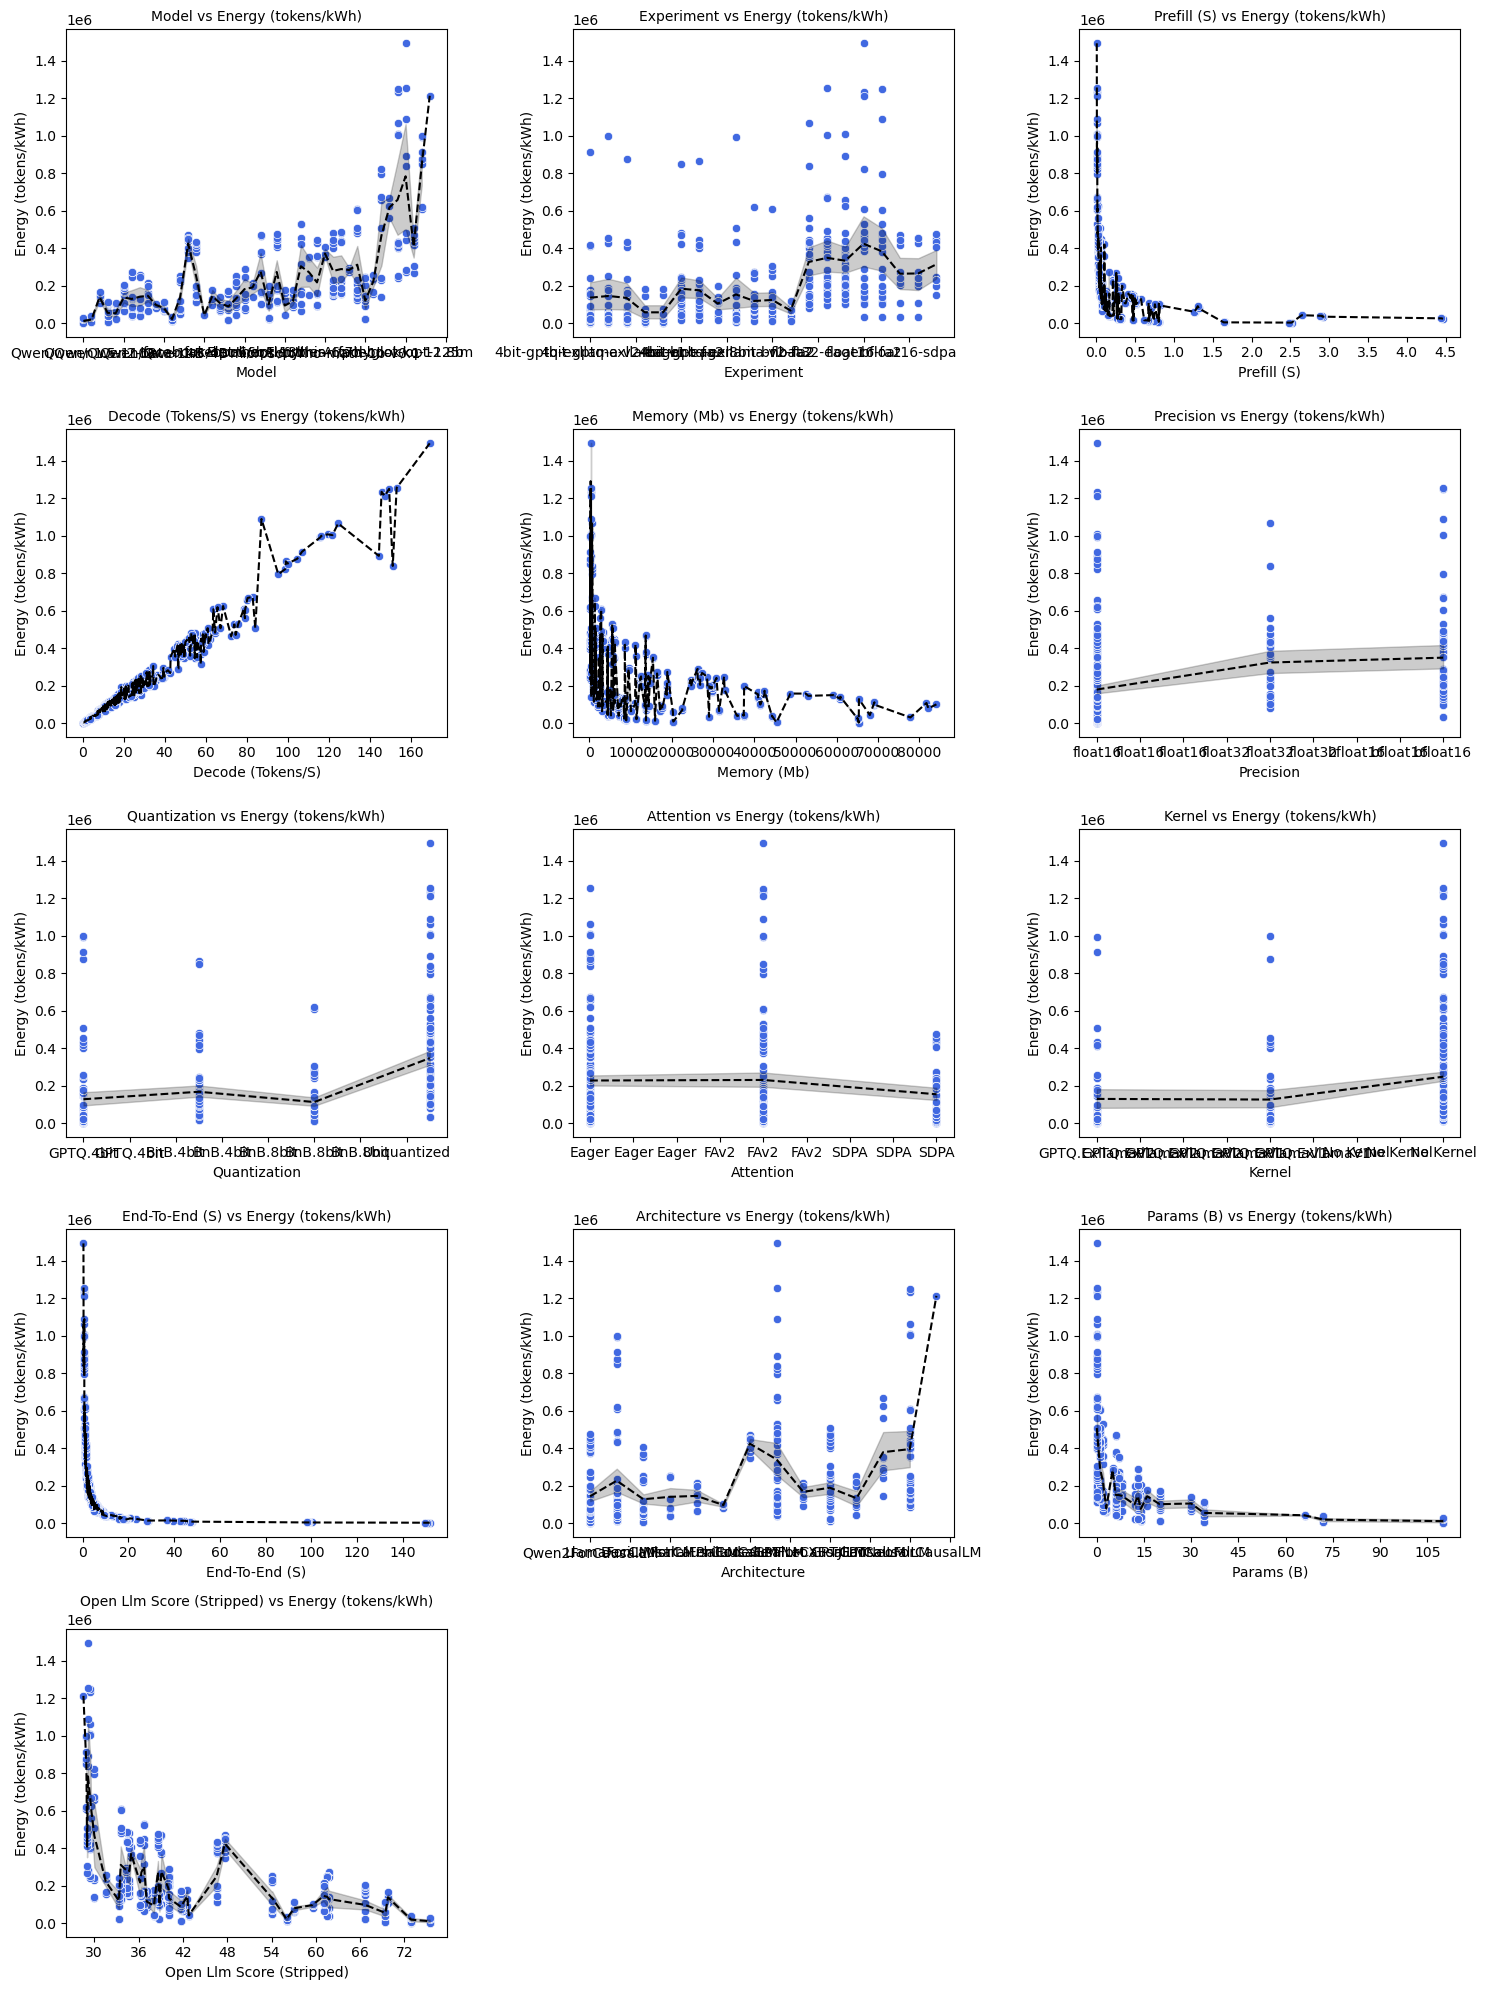

In [49]:
# Run this version with regression lines 
gg_scatterplots(data, y_variable='Energy (tokens/kWh)')

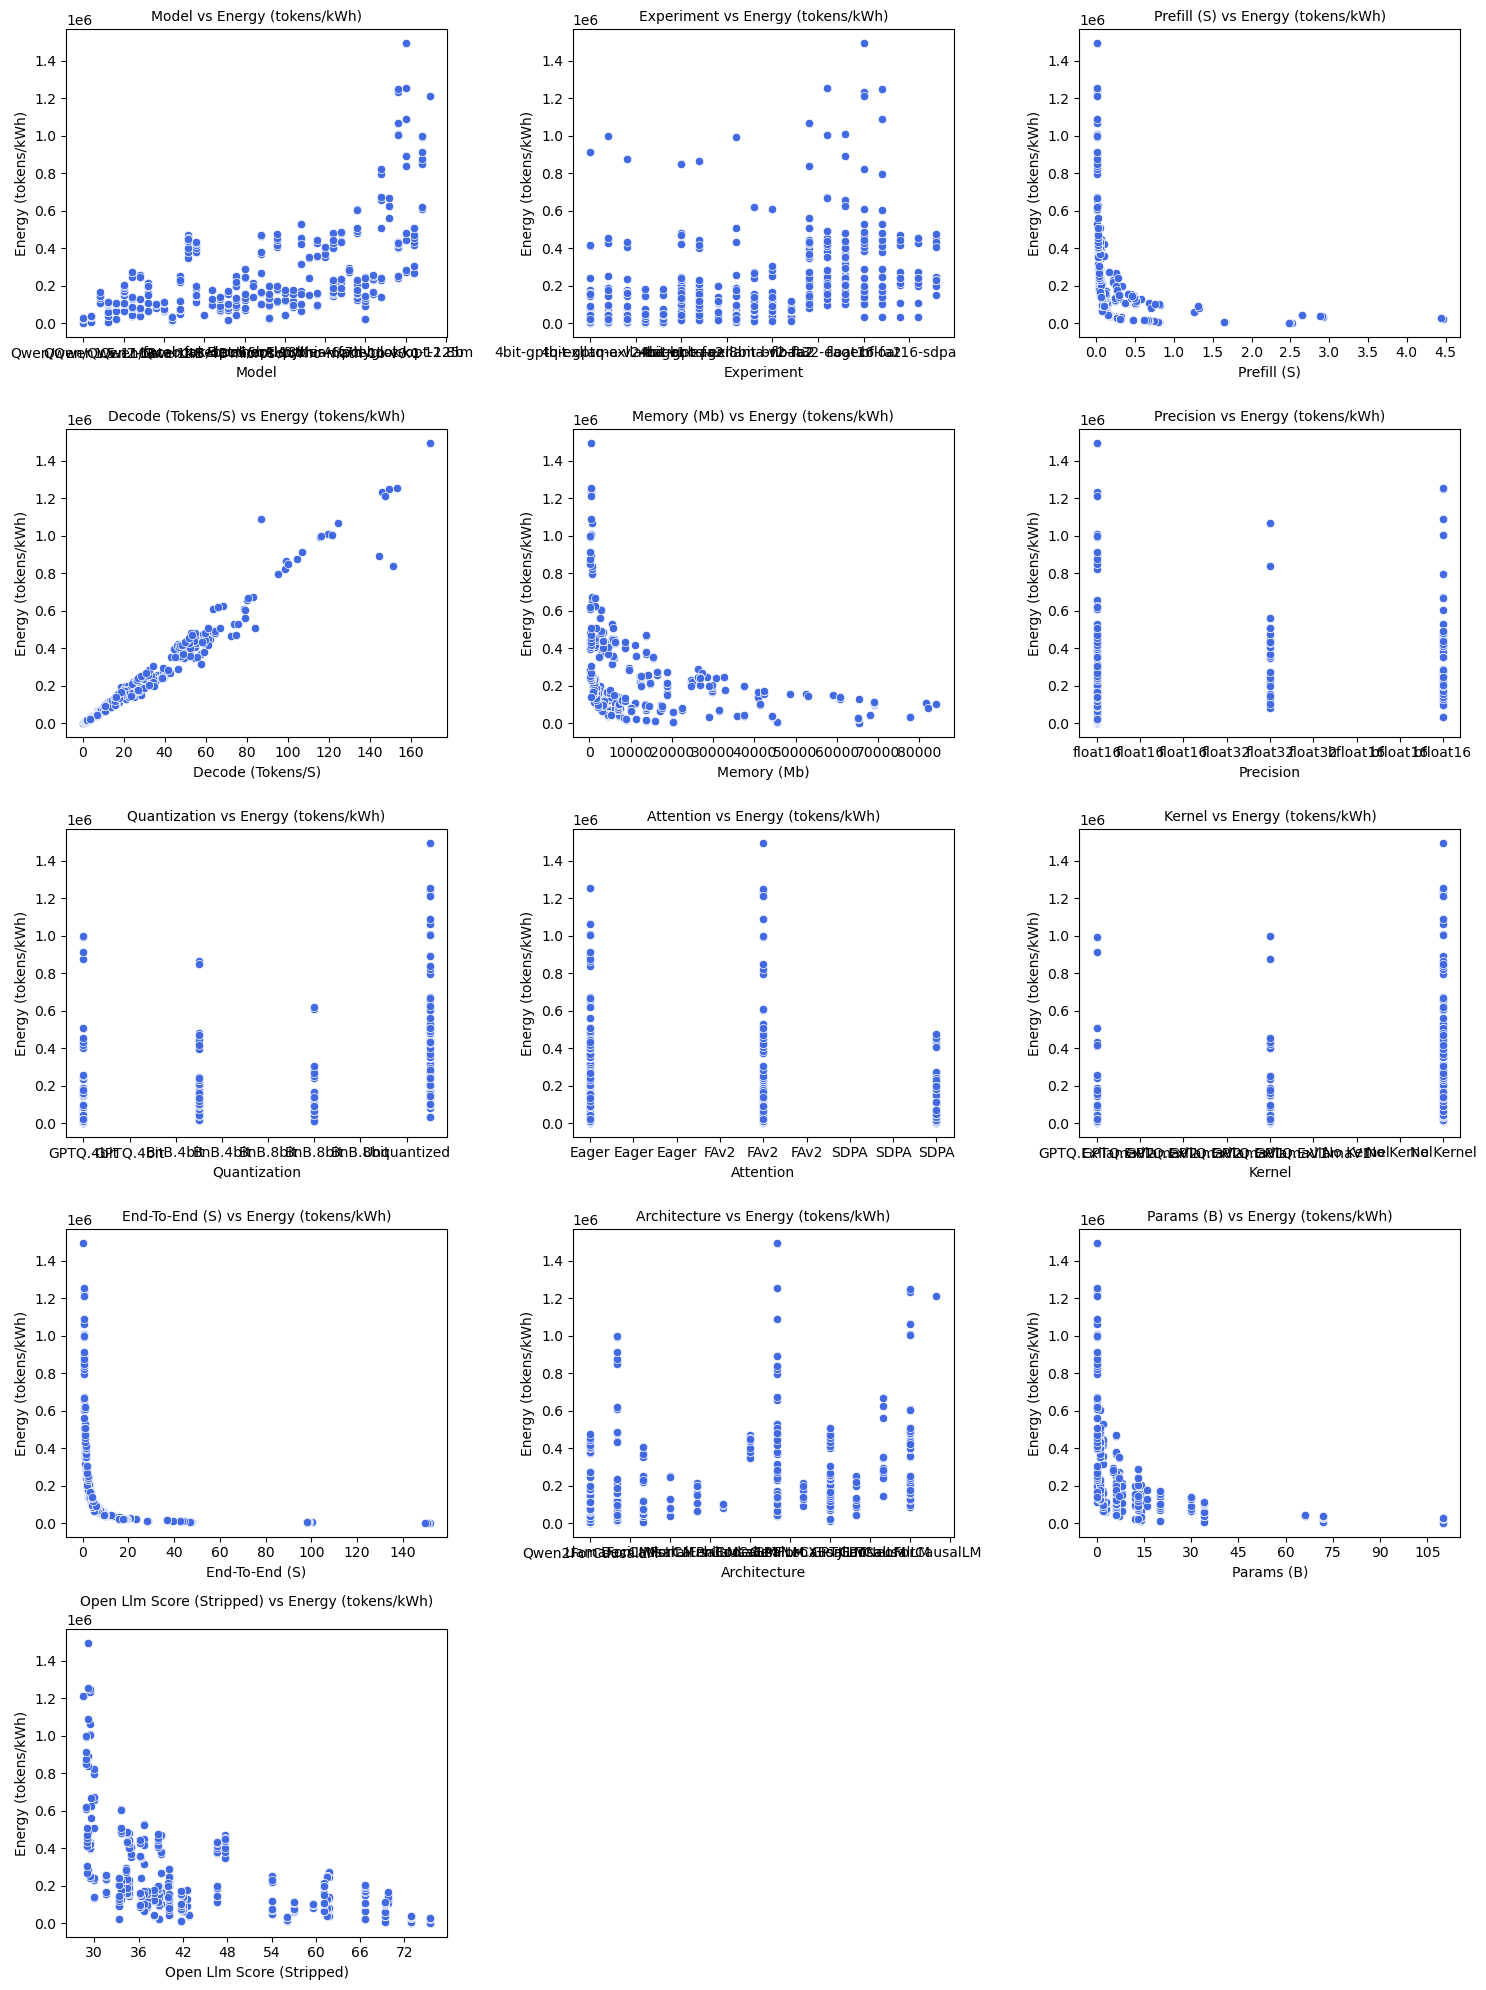

In [51]:
# Run without regression lines 
gg_scatterplots(data, y_variable='Energy (tokens/kWh)')

Pull out Open LLM Score (%), Energy Bins, Params Bins, Memory Bins, open llm bins, Backend from chart generation

Relationships by inspection:
1) Energy (tokens/kWh) negative log relationship with Open LLM Score %
2) Energy (tokens/kWh) negative log relationship with Params (B)
3) Energy (tokens/kWh) negative log relatipnship with Memory (MB)

Let's look at params plotted against Open LLM Score and Memory plotted against Open LLM Score

In [52]:
# limit data to only memory, open llm score, and params variables
data_limited = data[['Open LLM Score (stripped)', 'Memory (MB)', 'Params (B)']]
data_limited.head()

,Open LLM Score (stripped),Memory (MB),Params (B)
0,75.42,65311.037,110
1,75.42,65311.036,110
2,75.42,65311.037,110
3,75.42,65311.036,110
4,75.42,65311.036,110


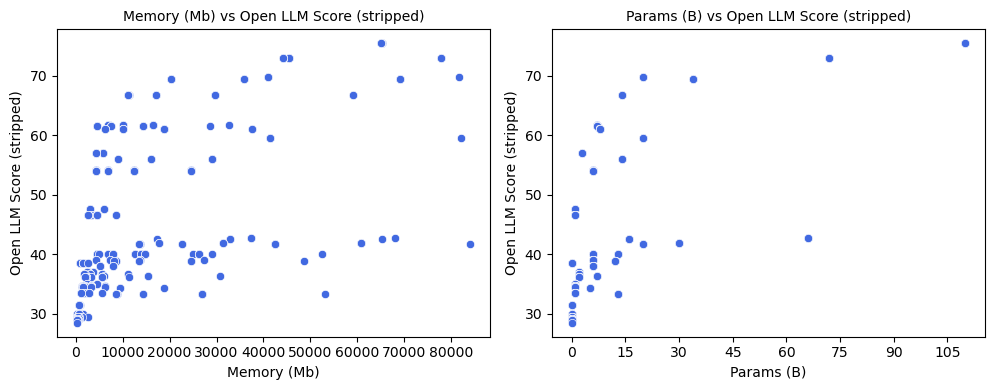

In [53]:
gg_scatterplots(data_limited, y_variable='Open LLM Score (stripped)')

Both variables share positive linear relationships with Open LLM Score %